## Analyze A/B Test Results


## Table of Contents
- [Introduction](#intro)
- [Part I - Probability](#probability)
- [Part II - A/B Test](#ab_test)
- [Part III - Regression](#regression)


<a id='intro'></a>
### Introduction 

For this project, I will be working to understand the results of an A/B test run by an e-commerce website.  The goal is to help the company understand if they should implement the a new landing page, keep the old landing page, or perhaps run the experiment longer to make their decision.


<a id='probability'></a>
### Part I - Probability


In [43]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline

a. Read in the dataset and take a look at the top few rows:

In [44]:
df = pd.read_csv('ab_data.csv')

df.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


b. The number of rows in the dataset:

In [45]:
df.shape

(294478, 5)

c. The number of unique users in the dataset:

In [46]:
df['user_id'].nunique()

290584

d. The proportion of users converted:

In [47]:
df['converted'].sum()/df.shape[0]

0.11965919355605512

e. The number of times the `new_page` and `treatment` don't line up:

In [48]:
df.query('(group == "control" and landing_page == "new_page") or (group == "treatment" and landing_page == "old_page")').count() 

user_id         3893
timestamp       3893
group           3893
landing_page    3893
converted       3893
dtype: int64

f. Do any of the rows have missing values:

In [49]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294478 entries, 0 to 294477
Data columns (total 5 columns):
user_id         294478 non-null int64
timestamp       294478 non-null object
group           294478 non-null object
landing_page    294478 non-null object
converted       294478 non-null int64
dtypes: int64(2), object(3)
memory usage: 11.2+ MB


g. For the rows where **treatment** is not aligned with **new_page** or **control** is not aligned with **old_page**, we cannot be sure if this row truly received the new or old page.  Remove these rows and store new dataframe in **df2**:

In [50]:
df2 = df.query('(group == "control" and landing_page == "old_page") or (group == "treatment" and landing_page == "new_page")')

h. Make sure all of the rows where removed:

In [51]:
df2[((df2['group'] == 'treatment') == (df2['landing_page'] == 'new_page')) == False].shape[0]

0

i. How many unique **user_id**s are in **df2**:

In [52]:
df2['user_id'].nunique()

290584

j. Are there any duplicate **user_id**'s in **df2**:

In [53]:
df2[df2['user_id'].duplicated(keep=False)]    

,user_id,timestamp,group,landing_page,converted
1899,773192,2017-01-09 05:37:58.781806,treatment,new_page,0
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


k. Remove **one** of the rows with a duplicate **user_id**:

In [54]:
df2.drop_duplicates('user_id',inplace=True)

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [55]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 290584 entries, 0 to 294477
Data columns (total 5 columns):
user_id         290584 non-null int64
timestamp       290584 non-null object
group           290584 non-null object
landing_page    290584 non-null object
converted       290584 non-null int64
dtypes: int64(2), object(3)
memory usage: 13.3+ MB


l. What is the probability of an individual converting regardless of the page they receive:

In [56]:
df2['converted'].mean()

0.11959708724499628

m. Given that an individual was in the `control` group, what is the probability they converted:

In [57]:
df2.query('group == "control"')['converted'].mean()

0.1203863045004612

n. Given that an individual was in the `treatment` group, what is the probability they converted:

In [58]:
df2.query('group == "treatment"')['converted'].mean()

0.11880806551510564

o. What is the probability that an individual received the new page:

In [59]:
df2.query('landing_page == "new_page"').shape[0]/df2.shape[0]

0.5000619442226688

**Analysis**

The control group conversion rate is slightly higher than the average conversion rate of the treatmeant group, but the conversion rates are very close. Therefore, there is not sufficient evidence to suggest that one page leads to more conversions than another.

<a id='ab_test'></a>
### Part II - A/B Test

Let's create a null and alternative hypothesis assuming the old page is better unless the new page proves to be definitely better at a Type I error rate of 5%:

**$p_{old}$** - conversion rate for the old landing page  
**$p_{new}$** - conversion rate for the new landing page<br><br>

Null:        **$p_{old}$** - **$p_{new}$** >= 0

Alternative: **$p_{old}$** - **$p_{new}$** < 0<br><br>


Assume under the null hypothesis, $p_{new}$ and $p_{old}$ both have "true" success rates equal to the **converted** success rate regardless of page - that is $p_{new}$ and $p_{old}$ are equal. Furthermore, assume they are equal to the **converted** rate in **ab_data.csv** regardless of the page. <br><br>

Use a sample size for each page equal to the ones in **ab_data.csv**.  <br><br>

Perform the sampling distribution for the difference in **converted** between the two pages over 10,000 iterations of calculating an estimate from the null.

a. What is the **convert rate** for $p_{new}$ and $p_{old}$ under the null:

In [60]:
df2['converted'].mean()

0.11959708724499628

In [61]:
convert_rate = df2['converted'].mean()

b. What is the sample size for the new landing page ($n_{new}$):

In [62]:
size_new = df2.query('landing_page == "new_page"').shape[0]
size_new

145310

c. What is the sample size for the old landing page ($n_{old}$):

In [63]:
size_old = df2.query('landing_page == "old_page"').shape[0]
size_old

145274

d. Simulate $n_{new}$ transactions with a convert rate of $p_{new}$ under the null.  Store these $n_{new}$ 1's and 0's in **new_page_converted**:

In [64]:
new_page_converted = np.random.choice(2, size_new, replace=True, p=[1-convert_rate, convert_rate])

e. Simulate $n_{old}$ transactions with a convert rate of $p_{old}$ under the null.  Store these $n_{old}$ 1's and 0's in **old_page_converted**:

In [65]:
old_page_converted = np.random.choice(2, size_old, replace=True, p=[1-convert_rate, convert_rate])

f. Find $p_{new}$ - $p_{old}$ for your simulated values:

In [66]:
new_page_converted.mean() - old_page_converted.mean()

-0.00082118555319167508

g. Simulate 10,000 $p_{new}$ - $p_{old}$ values using this same process. Store all 10,000 values in **p_diffs**:

In [67]:
p_diffs = []

for _ in range(10000):
    old_sample = np.random.choice(2, size_old, replace=True, p=[1-convert_rate, convert_rate])
    new_sample = np.random.choice(2, size_new, replace=True, p=[1-convert_rate, convert_rate])
    p_diffs.append(new_sample.mean() - old_sample.mean())

h. Plot a histogram of the **p_diffs**:

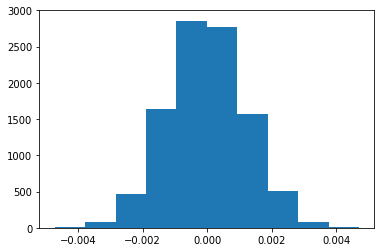

In [68]:
plt.hist(p_diffs);

i. What proportion of the **p_diffs** are greater than the actual difference observed in **ab_data.csv**:

In [69]:
actual_diff = df2.query('landing_page == "new_page"')['converted'].mean() - df2.query('landing_page == "old_page"')['converted'].mean()

In [70]:
actual_diff

-0.0015782389853555567

In [71]:
(p_diffs > actual_diff).mean()

0.90680000000000005

j. This is the p-value (0.90680000000000005). Since the p-value is greater than the critical value of 5%, we cannot reject the null hypothesis.  

In other words, the difference between $p_{new}$ and $p_{old}$ in our 10,000 simulations is greater than the difference in $p_{new}$ and $p_{old}$ from our dataset about 90.68% of the time. Therefore, we cannot reject the null hypothesis.

k. We could also use a built-in to achieve similar results:

In [72]:
import statsmodels.api as sm

convert_old = df2.query('landing_page == "old_page" and converted == 1').shape[0]
convert_new = df2.query('landing_page == "new_page" and converted == 1').shape[0]
n_old = df2.query('landing_page == "old_page"').shape[0]
n_new = df2.query('landing_page == "new_page"').shape[0]

l. Now use `stats.proportions_ztest` to compute your test statistic and p-value:

In [73]:
z_score, p_value = sm.stats.proportions_ztest([convert_old, convert_new],[n_old, n_new], alternative='smaller')

print('P-value: {}'.format(p_value))
print('Z-score: {}'.format(z_score))

P-value: 0.9050583127590245
Z-score: 1.3109241984234394


m. We can see a similar p-value as to what we previously calculated. The z-score indicates the distance from our sample to mean to the population mean in units of standard deviation. Our sample mean is about 1.31 standard deviations from our population mean.

<a id='regression'></a>
### Part III - A regression approach

In this final part, we will see that the result acheived in the previous A/B test can also be acheived by performing logisitic regression. The goal is to use **statsmodels** to fit a regression model to see if there is a significant difference in conversion based on which page a customer receives.<br><br>

a. First, we need to create a column for the intercept, and create a dummy variable column for which page each user received.  Add an **intercept** column, and an **ab_page** column (1 when an individual receives the **treatment** and 0 if **control**):

In [74]:
df2['intercept'] = 1
df2['ab_page'] = pd.get_dummies(df2['group'])['treatment']

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [75]:
df2.head()

,user_id,timestamp,group,landing_page,converted,intercept,ab_page
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,1,0


c. Use **statsmodels** to import the regression model.  Instantiate and fit the model using the two columns created to predict whether or not an individual converts:

In [76]:
logit_mod = sm.Logit(df2['converted'], df2[['intercept', 'ab_page']])
results = logit_mod.fit()

Optimization terminated successfully.
         Current function value: 0.366118
         Iterations 6


d. Provide the summary of your model:

In [77]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290582
Method:                           MLE   Df Model:                            1
Date:                Mon, 17 Sep 2018   Pseudo R-squ.:               8.077e-06
Time:                        23:22:21   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
                                        LLR p-value:                    0.1899
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9888      0.008   -246.669      0.000      -2.005      -1.973
ab_page       -0.0150      0.011     -1.311      0.190      -0.037       0.007
==============================================================================
"""

e. The p-value in the regression model is 0.19. There is a difference in this p-value and our previous p-value because this is a two-sided test. 